In [1]:
import numpy
import tqdm
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot
from joblib import dump, load
from sklearn.neural_network import MLPClassifier
from dirichlet_python.dirichletcal.calib.tempscaling import TemperatureScaling
%matplotlib inline

In [2]:
# specify the dataset settings (a mixutre of gaussian)

pi = numpy.ones(3) / 3
ita_0 = numpy.array([0.5, 0.5])
ita_1 = numpy.array([0.5, 0.5])
mu_0_0 = numpy.array([4.0]) 
mu_0_1 = numpy.array([-64.0]) 
mu_1_0 = numpy.array([-4.0])
mu_1_1 = numpy.array([72.0 ]) 
cov_0_0 = numpy.array([960.0])
cov_0_1 = numpy.array([1280.0])
cov_1_0 = numpy.array([980.0])
cov_1_1 = numpy.array([1024.0])

ita_2 = numpy.array([0.5, 0.5])
mu_2_0 = numpy.array([0.0]) 
mu_2_1 = numpy.array([0.0]) 
cov_2_0 = numpy.array([8.0])
cov_2_1 = numpy.array([8.0])

In [3]:
# specify the visualisation settings

N_grid = 1024
edge = 160.0
v_edge = 160.0
x_mesh_raw = numpy.linspace(-edge, edge, N_grid).reshape(-1, 1)
x_mesh = numpy.linspace(-edge, edge, N_grid).reshape(-1, 1)

In [4]:
# calculate the corresponding densities and probabilities

p_x_y = numpy.vstack([pi[0] * ita_0[0] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_0_0, cov=cov_0_0) +
                      pi[1] * ita_0[1] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_0_1, cov=cov_0_1),
                      pi[1] * ita_1[0] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_1_0, cov=cov_1_0) +
                      pi[1] * ita_1[1] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_1_1, cov=cov_1_1),
                      pi[2] * ita_2[0] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_2_0, cov=cov_2_0) +
                      pi[2] * ita_2[1] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_2_1, cov=cov_2_1)])

p_x =  numpy.sum(p_x_y, axis=0)

p_y_g_x = p_x_y / p_x

p_x = p_x
p_x_y = p_x_y
p_x_g_y = p_x_y / pi.reshape(-1, 1)

In [5]:
N = 10000
y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1, pi[2]*ita_2]), size=N, n=1)
x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_2_0, cov=cov_2_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_2_1, cov=cov_2_1, size=N).reshape(-1, 1)]

x = x[0] * y[:, 0].reshape(-1, 1) + x[1] * y[:, 1].reshape(-1, 1) + \
    x[2] * y[:, 2].reshape(-1, 1) + x[3] * y[:, 3].reshape(-1, 1) + \
    x[4] * y[:, 4].reshape(-1, 1) + x[5] * y[:, 5].reshape(-1, 1)

y = numpy.vstack([y[:, 0] + y[:, 1],
                  y[:, 2] + y[:, 3],
                  y[:, 4] + y[:, 5]]).transpose()

In [6]:
mdl = load('models/mlp_3.joblib')

In [7]:
# get predicted scores on samples
s = mdl.predict_proba(x)

In [8]:
cal = TemperatureScaling()
cal.fit(s, numpy.argmax(y,axis=1))

/home/sh/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/sh/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sh/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


TemperatureScaling()

In [9]:
# get predicted scores on an interval
N_grid = 1024
edge = 160.0
v_edge = 160.0
x_mesh = numpy.linspace(-edge, edge, N_grid).reshape(-1, 1)
s_mesh = mdl.predict_proba(x_mesh)
s_cal_mesh = cal.predict_proba(s_mesh)

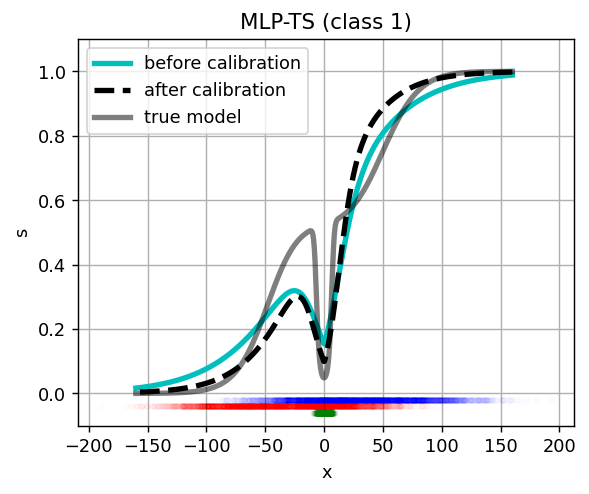

In [10]:
matplotlib.pyplot.figure(dpi=128, figsize=(5, 4))
matplotlib.pyplot.plot(-x_mesh, s_mesh[:, 0], 'c', linewidth=3.0)
matplotlib.pyplot.plot(-x_mesh, s_cal_mesh[:, 0], 'k--', linewidth=3.0)
matplotlib.pyplot.plot(-x_mesh_raw, p_y_g_x[0], 'k', linewidth=3.0, alpha=0.5)
matplotlib.pyplot.plot(-x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(-x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(-x[y[:, 2]==1], numpy.zeros(numpy.sum(y[:, 2]==1)) - 6e-2, 'go', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('s')
matplotlib.pyplot.title('MLP-TS (class 1)')
matplotlib.pyplot.ylim([-0.1, 1.1])
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(['before calibration', 'after calibration', 'true model'])

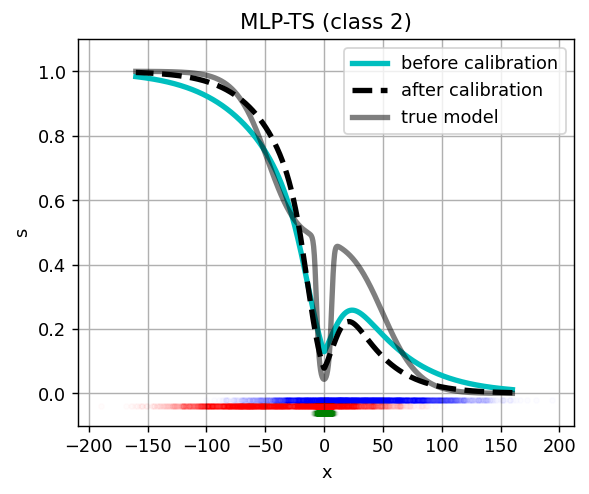

In [11]:
matplotlib.pyplot.figure(dpi=128, figsize=(5, 4))
matplotlib.pyplot.plot(-x_mesh, s_mesh[:, 1], 'c', linewidth=3.0)
matplotlib.pyplot.plot(-x_mesh, s_cal_mesh[:, 1], 'k--', linewidth=3.0)
matplotlib.pyplot.plot(-x_mesh_raw, p_y_g_x[1], 'k', linewidth=3.0, alpha=0.5)
matplotlib.pyplot.plot(-x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(-x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(-x[y[:, 2]==1], numpy.zeros(numpy.sum(y[:, 2]==1)) - 6e-2, 'go', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('s')
matplotlib.pyplot.title('MLP-TS (class 2)')
matplotlib.pyplot.ylim([-0.1, 1.1])
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(['before calibration', 'after calibration', 'true model'])

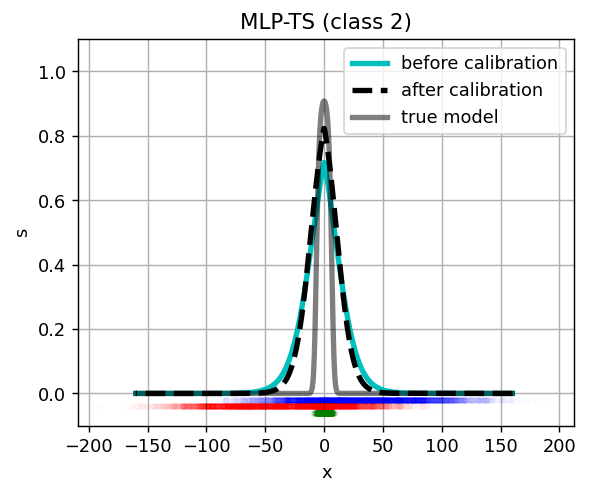

In [12]:
matplotlib.pyplot.figure(dpi=128, figsize=(5, 4))
matplotlib.pyplot.plot(-x_mesh, s_mesh[:, 2], 'c', linewidth=3.0)
matplotlib.pyplot.plot(-x_mesh, s_cal_mesh[:, 2], 'k--', linewidth=3.0)
matplotlib.pyplot.plot(-x_mesh_raw, p_y_g_x[2], 'k', linewidth=3.0, alpha=0.5)
matplotlib.pyplot.plot(-x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(-x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(-x[y[:, 2]==1], numpy.zeros(numpy.sum(y[:, 2]==1)) - 6e-2, 'go', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('s')
matplotlib.pyplot.title('MLP-TS (class 2)')
matplotlib.pyplot.ylim([-0.1, 1.1])
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(['before calibration', 'after calibration', 'true model'])

In [13]:
N_grid = 1024
simp_1_grid = numpy.linspace(0.0, 2.0, N_grid)
simp_2_grid = numpy.linspace(0.0, numpy.sqrt(3), N_grid)
simp_1_mesh, simp_2_mesh = numpy.meshgrid(simp_1_grid, simp_2_grid)
simp_mesh = numpy.hstack([simp_1_mesh.reshape(-1, 1), simp_2_mesh.reshape(-1, 1)])
s_mesh = numpy.hstack([(simp_mesh[:, 1] / numpy.sqrt(3)).reshape(-1, 1), 
                       ((simp_mesh[:, 0] - (simp_mesh[:, 1] / numpy.sqrt(3))) / 2).reshape(-1, 1)])
s_mesh = numpy.hstack([s_mesh, 1 - numpy.sum(s_mesh, axis=1).reshape(-1, 1)])

In [14]:
s_hat = cal.predict_proba(s_mesh)

In [15]:
s_mesh_valid = s_mesh[(numpy.sum(s_mesh, axis=1)<=1.0) & (numpy.min(s_mesh, axis=1)>=0.0), :]
s_hat_valid = s_hat[(numpy.sum(s_mesh, axis=1)<=1.0) & (numpy.min(s_mesh, axis=1)>=0.0), :]

In [16]:
vmax = numpy.max(numpy.abs(s_hat_valid - s_mesh_valid))

([], <a list of 0 Text major ticklabel objects>)

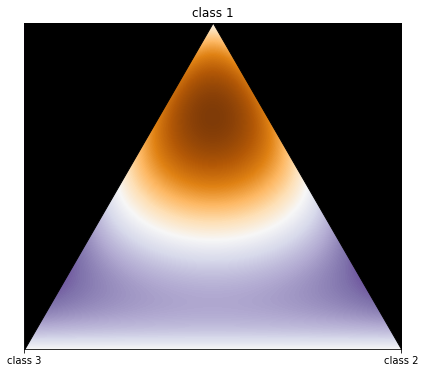

In [17]:
matplotlib.pyplot.figure(figsize=(8.0, 6.0))
matplotlib.pyplot.fill_between(numpy.linspace(0, 1, 8), numpy.ones(8) * numpy.sqrt(3), numpy.linspace(0, 1, 8) * numpy.sqrt(3), 
                       facecolor='k', edgecolor='k', zorder=1)
matplotlib.pyplot.fill_between(numpy.linspace(1, 2, 8), numpy.ones(8) * numpy.sqrt(3), 
                       numpy.linspace(1, 2, 8) * -numpy.sqrt(3) + 2*numpy.sqrt(3), 
                       facecolor='k', edgecolor='k', zorder=1)
matplotlib.pyplot.fill_between(numpy.linspace(0, 2, 8), numpy.zeros(8) * numpy.sqrt(3), numpy.ones(8) * numpy.sqrt(3), 
                               facecolor='w', edgecolor='w', zorder=-1)
matplotlib.pyplot.imshow((s_hat[:, 0] - s_mesh[:, 0]).reshape(N_grid, N_grid), origin='lower', cmap='PuOr_r', 
                         extent=[0, 2, 0, numpy.sqrt(3)], vmax=vmax, vmin=-vmax)
matplotlib.pyplot.xticks([0.0, 2.0], ['class 3', 'class 2'])
matplotlib.pyplot.title('class 1')
matplotlib.pyplot.yticks([])

([], <a list of 0 Text major ticklabel objects>)

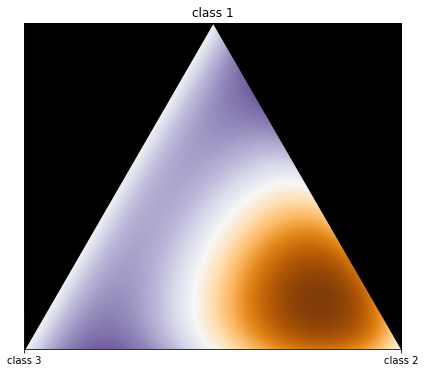

In [18]:
matplotlib.pyplot.figure(figsize=(8.0, 6.0))
matplotlib.pyplot.fill_between(numpy.linspace(0, 1, 8), numpy.ones(8) * numpy.sqrt(3), numpy.linspace(0, 1, 8) * numpy.sqrt(3), 
                       facecolor='k', edgecolor='k', zorder=1)
matplotlib.pyplot.fill_between(numpy.linspace(1, 2, 8), numpy.ones(8) * numpy.sqrt(3), 
                       numpy.linspace(1, 2, 8) * -numpy.sqrt(3) + 2*numpy.sqrt(3), 
                       facecolor='k', edgecolor='k', zorder=1)
matplotlib.pyplot.fill_between(numpy.linspace(0, 2, 8), numpy.zeros(8) * numpy.sqrt(3), numpy.ones(8) * numpy.sqrt(3), 
                               facecolor='w', edgecolor='w', zorder=-1)
matplotlib.pyplot.imshow((s_hat[:, 1] - s_mesh[:, 1]).reshape(N_grid, N_grid), origin='lower', cmap='PuOr_r', 
                         extent=[0, 2, 0, numpy.sqrt(3)], vmax=vmax, vmin=-vmax)
matplotlib.pyplot.xticks([0.0, 2.0], ['class 3', 'class 2'])
matplotlib.pyplot.title('class 1')
matplotlib.pyplot.yticks([])

([], <a list of 0 Text major ticklabel objects>)

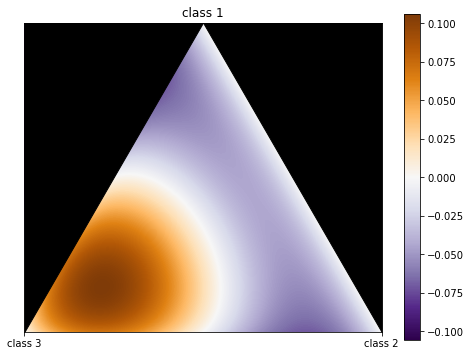

In [19]:
matplotlib.pyplot.figure(figsize=(8.0, 6.0))
matplotlib.pyplot.fill_between(numpy.linspace(0, 1, 8), numpy.ones(8) * numpy.sqrt(3), numpy.linspace(0, 1, 8) * numpy.sqrt(3), 
                       facecolor='k', edgecolor='k', zorder=1)
matplotlib.pyplot.fill_between(numpy.linspace(1, 2, 8), numpy.ones(8) * numpy.sqrt(3), 
                       numpy.linspace(1, 2, 8) * -numpy.sqrt(3) + 2*numpy.sqrt(3), 
                       facecolor='k', edgecolor='k', zorder=1)
matplotlib.pyplot.fill_between(numpy.linspace(0, 2, 8), numpy.zeros(8) * numpy.sqrt(3), numpy.ones(8) * numpy.sqrt(3), 
                               facecolor='w', edgecolor='w', zorder=-1)
matplotlib.pyplot.imshow((s_hat[:, 2] - s_mesh[:, 2]).reshape(N_grid, N_grid), origin='lower', cmap='PuOr_r', 
                         extent=[0, 2, 0, numpy.sqrt(3)], vmax=vmax, vmin=-vmax)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.xticks([0.0, 2.0], ['class 3', 'class 2'])
matplotlib.pyplot.title('class 1')
matplotlib.pyplot.yticks([])